In [1]:
import numpy as np
from utils.dataloader import ClsDatasets
from utils.utils import get_classes

# 1.获取类别和数量

In [2]:
classes_path = '../path_txt/cls_classes.txt'
class_names, num_classes = get_classes(classes_path) #得到类别与种类个数

In [3]:
print(class_names, num_classes)

['Retinopathy_grade_0', 'Retinopathy_grade_1', 'Retinopathy_grade_2', 'Retinopathy_grade_3'] 4


# 2.获取训练集和验证集

In [4]:
#annotation_path = "../path_txt/test_stable/train_val.txt"
annotation_path = "cls_train_val_Contrast_stretching_banlance.txt"
val_split       = 0.2

with open(annotation_path, "r") as f:
    lines = f.readlines()

In [5]:
len(lines)

2689

In [6]:
#不划分训练集和验证集时，做K折交叉验证
train_val_path = lines
np.random.seed(2022)
np.random.shuffle(train_val_path)
np.random.seed(None)

In [7]:
#annotation_path = "../path_txt/test_stable/test.txt"
annotation_path = "cls_test_Contrast_stretching_banlance.txt"

with open(annotation_path, "r") as f:
    test_path = f.readlines()

# 3.得到训练和验证的数据

In [8]:
train_val_dataloader    = ClsDatasets(train_val_path, [224, 224], 1, num_classes, train = False)

In [9]:
X_train_val = []
Y_train_val =[]

for x,y in train_val_dataloader:
    X_train_val.append(x)
    Y_train_val.append(y)

X_train_val = np.asarray(X_train_val)
Y_train_val = np.asarray(Y_train_val)

X_train_val = np.squeeze(X_train_val, 1)
Y_train_val = np.squeeze(Y_train_val, 1)

Y_train_val = np.argmax(Y_train_val,axis=1)

In [10]:
X_train_val.shape

(2689, 224, 224, 3)

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

In [12]:
a = X_train_val[0]

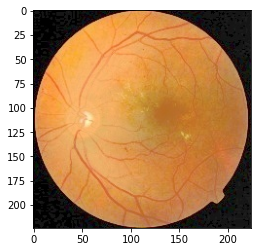

In [13]:
plt.imshow(a/255.0)

# 变为灰度图

In [14]:
import cv2 

In [15]:
X_train_val_grey = []
for image in X_train_val:
    imGray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    X_train_val_grey.append(imGray)

In [16]:
X_train_val_grey = np.asarray(X_train_val_grey)

In [17]:
X_train_val_grey.shape

(2689, 224, 224)

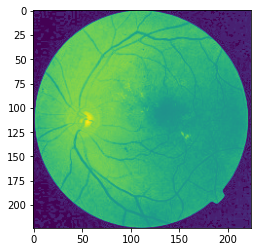

In [18]:
plt.imshow(X_train_val_grey[0])

In [19]:
#X_train_val_grey = X_train_val #不变成灰度图

In [20]:
X_train_val_grey.shape

(2689, 224, 224)

# 4.特征提取

## 4.1HOG 

In [21]:
from skimage.feature import hog

In [22]:
X_train_val_hog = []

for image in X_train_val_grey:
    image = hog(image, orientations=8, block_norm='L2', pixels_per_cell=[4, 4], cells_per_block=[2, 2], 
                visualize=False)
    X_train_val_hog.append(image)

In [23]:
X_train_val_hog = np.asarray(X_train_val_hog)

In [24]:
X_train_val_hog.shape

(2689, 96800)

In [25]:
a,b = hog(X_train_val_grey[0], orientations=8, block_norm='L2', pixels_per_cell=[4, 4], cells_per_block=[2, 2], 
                visualize=True)

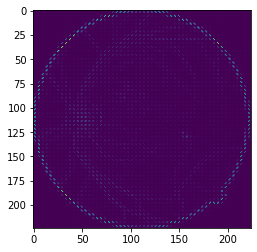

In [26]:
plt.imshow(b)

In [27]:
a.shape

(96800,)

In [28]:
np.asarray(range(96800)).shape

(96800,)

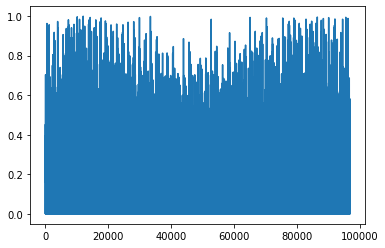

In [29]:
plt.plot(np.asarray(range(96800)), a)
plt.show()

In [31]:
#plt.imshow(np.reshape(X_train_val_hog[0],(162,162)))

In [21]:
X_train_val_hog = np.reshape(X_train_val_grey,(2689,224*224)) #不用HOG的时候运行

In [22]:
X_train_val_hog.shape

(2689, 50176)

In [23]:
from sklearn.decomposition import PCA

In [24]:
pca = PCA(n_components=200)
X_train_val_hog_pca = pca.fit_transform(X_train_val_hog)

In [25]:
X_train_val_hog_pca.shape

(2689, 200)

In [31]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_train_val_hog, Y_train_val = ros.fit_resample(X_train_val_hog, Y_train_val)

In [35]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_train_val_hog_pca, Y_train_val = ros.fit_resample(X_train_val_hog_pca, Y_train_val)

# 分类算法

In [28]:
from sklearn.model_selection import cross_val_score 

# KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier
# 建立Knn模型
knn = KNeighborsClassifier(n_neighbors=20)

# 使用K折交叉验证模块
scores = cross_val_score(knn, X_train_val_hog_pca, Y_train_val, cv=5, scoring='accuracy')

# 将5次的预测准确率打印出
print(scores)

#将5次的预测准确平均率打印出
print(scores.mean())

[0.56319703 0.5464684  0.57063197 0.60223048 0.54003724]
0.5645130249977501


In [30]:
knn.fit(X_train_val_hog_pca, Y_train_val)

KNeighborsClassifier(n_neighbors=20)

In [31]:
from sklearn.metrics import precision_score,recall_score,f1_score

x_val_for_test_pca = pca.transform(x_val_for_test)
Y_pred_val = knn.predict(x_val_for_test_pca)
accuracy = knn.score(x_val_for_test_pca, Y_actual_val)  
precision = precision_score(Y_actual_val, Y_pred_val, average='weighted')
recall = recall_score(Y_actual_val, Y_pred_val, average='weighted')
f1 = f1_score(Y_actual_val, Y_pred_val, average='weighted')

print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1: {:.2f}%'.format(f1 * 100))

Accuracy: 55.67%
Precision: 55.34%
Recall: 55.67%
F1: 54.17%


# 给SVM加一个标准化，太慢了

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
scaler = StandardScaler()

In [34]:
x_train_nor = scaler.fit_transform(X_train_val_hog_pca)

# SVM

In [35]:
from sklearn.svm import SVC

svc_cls = SVC(C=0.01, gamma=0.001, kernel='linear')
#svc_cls = SVC()
# 使用K折交叉验证模块
scores = cross_val_score(svc_cls, x_train_nor, Y_train_val, cv=5, scoring='accuracy')

# 将5次的预测准确率打印出
print(scores)

#将5次的预测准确平均率打印出
print(scores.mean())

[0.64498141 0.61710037 0.61710037 0.66171004 0.63873371]
0.6359251798162725


In [36]:
svc_cls.fit(x_train_nor, Y_train_val)

SVC(C=0.01, gamma=0.001, kernel='linear')

In [37]:
from sklearn.metrics import precision_score,recall_score,f1_score

x_val_for_test_pca = pca.transform(x_val_for_test)
x_val_for_test_pca = scaler.transform(x_val_for_test_pca)
Y_pred_val = svc_cls.predict(x_val_for_test_pca)
accuracy = svc_cls.score(x_val_for_test_pca, Y_actual_val)  
precision = precision_score(Y_actual_val, Y_pred_val, average='weighted')
recall = recall_score(Y_actual_val, Y_pred_val, average='weighted')
f1 = f1_score(Y_actual_val, Y_pred_val, average='weighted')

print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1: {:.2f}%'.format(f1 * 100))

Accuracy: 64.33%
Precision: 64.30%
Recall: 64.33%
F1: 62.40%


In [48]:
x_val_for_test.shape

(238, 96800)

# RF

In [38]:
from sklearn.ensemble import RandomForestClassifier#调用随机森林模型

In [39]:
RF_cls = RandomForestClassifier(n_estimators= 160, max_depth=11, max_features='sqrt', min_samples_leaf=10, min_samples_split=80)

# 使用K折交叉验证模块
scores = cross_val_score(RF_cls, X_train_val_hog_pca, Y_train_val, cv=5, scoring='accuracy')

# 将10次的预测准确率打印出
print(scores)

#将5次的预测准确平均率打印出
print(scores.mean())

[0.60966543 0.60966543 0.63011152 0.65241636 0.62197393]
0.6247665330591957


In [40]:
RF_cls.fit(X_train_val_hog_pca, Y_train_val)

RandomForestClassifier(max_depth=11, min_samples_leaf=10, min_samples_split=80,
                       n_estimators=160)

In [41]:
from sklearn.metrics import precision_score,recall_score,f1_score

x_val_for_test_pca = pca.transform(x_val_for_test)
Y_pred_val = RF_cls.predict(x_val_for_test_pca)
accuracy = RF_cls.score(x_val_for_test_pca, Y_actual_val)  
precision = precision_score(Y_actual_val, Y_pred_val, average='weighted')
recall = recall_score(Y_actual_val, Y_pred_val, average='weighted')
f1 = f1_score(Y_actual_val, Y_pred_val, average='weighted')

print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1: {:.2f}%'.format(f1 * 100))

Accuracy: 59.40%
Precision: 57.70%
Recall: 59.40%
F1: 55.77%


# DT

In [42]:
from sklearn.tree import DecisionTreeClassifier

In [43]:
dt_cls = DecisionTreeClassifier(max_depth=11, min_samples_leaf=10, min_samples_split=40)

# 使用K折交叉验证模块
scores = cross_val_score(dt_cls, X_train_val_hog_pca, Y_train_val, cv=5, scoring='accuracy')

# 将10次的预测准确率打印出
print(scores)

#将5次的预测准确平均率打印出
print(scores.mean())

[0.51115242 0.55762082 0.52230483 0.52788104 0.54562384]
0.5329165887866643


In [44]:
dt_cls.fit(X_train_val_hog_pca, Y_train_val)

DecisionTreeClassifier(max_depth=11, min_samples_leaf=10, min_samples_split=40)

In [45]:
from sklearn.metrics import precision_score,recall_score,f1_score

x_val_for_test_pca = pca.transform(x_val_for_test)
Y_pred_val = dt_cls.predict(x_val_for_test_pca)
accuracy = dt_cls.score(x_val_for_test_pca, Y_actual_val)  
precision = precision_score(Y_actual_val, Y_pred_val, average='weighted')
recall = recall_score(Y_actual_val, Y_pred_val, average='weighted')
f1 = f1_score(Y_actual_val, Y_pred_val, average='weighted')

print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1: {:.2f}%'.format(f1 * 100))

Accuracy: 52.39%
Precision: 51.38%
Recall: 52.39%
F1: 51.70%


# Adaboost

In [46]:
from sklearn.ensemble import AdaBoostClassifier

In [47]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=11, min_samples_leaf=10, min_samples_split=40))

# 使用K折交叉验证模块
scores = cross_val_score(clf, X_train_val_hog_pca, Y_train_val, cv=5, scoring='accuracy')

# 将10次的预测准确率打印出
print(scores)

#将5次的预测准确平均率打印出
print(scores.mean())

[0.57434944 0.59665428 0.55576208 0.60594796 0.59031657]
0.5846060656407273


In [48]:
clf.fit(X_train_val_hog_pca, Y_train_val)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=11,
                                                         min_samples_leaf=10,
                                                         min_samples_split=40))

In [49]:
from sklearn.metrics import precision_score,recall_score,f1_score

x_val_for_test_pca = pca.transform(x_val_for_test)
Y_pred_val = clf.predict(x_val_for_test_pca)
accuracy = clf.score(x_val_for_test_pca, Y_actual_val)  
precision = precision_score(Y_actual_val, Y_pred_val, average='weighted')
recall = recall_score(Y_actual_val, Y_pred_val, average='weighted')
f1 = f1_score(Y_actual_val, Y_pred_val, average='weighted')

print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1: {:.2f}%'.format(f1 * 100))

Accuracy: 60.00%
Precision: 61.71%
Recall: 60.00%
F1: 59.84%


# gradientboost

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

In [51]:
clf_grd = GradientBoostingClassifier(max_depth=7, max_features='sqrt', min_samples_leaf=10,
                                   min_samples_split=40, n_estimators=160, learning_rate=0.05, subsample=0.8)

# 使用K折交叉验证模块
scores = cross_val_score(clf_grd, X_train_val_hog_pca, Y_train_val, cv=5, scoring='accuracy')

# 将10次的预测准确率打印出
print(scores)

#将5次的预测准确平均率打印出
print(scores.mean())

[0.68215613 0.64498141 0.65427509 0.71747212 0.68901304]
0.6775795587492126


In [52]:
clf_grd.fit(X_train_val_hog_pca, Y_train_val)

GradientBoostingClassifier(learning_rate=0.05, max_depth=7, max_features='sqrt',
                           min_samples_leaf=10, min_samples_split=40,
                           n_estimators=160, subsample=0.8)

In [53]:
from sklearn.metrics import precision_score,recall_score,f1_score

x_val_for_test_pca = pca.transform(x_val_for_test)
Y_pred_val = clf_grd.predict(x_val_for_test_pca)
accuracy = clf_grd.score(x_val_for_test_pca, Y_actual_val)  
precision = precision_score(Y_actual_val, Y_pred_val, average='weighted')
recall = recall_score(Y_actual_val, Y_pred_val, average='weighted')
f1 = f1_score(Y_actual_val, Y_pred_val, average='weighted')

print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1: {:.2f}%'.format(f1 * 100))

Accuracy: 66.72%
Precision: 66.69%
Recall: 66.72%
F1: 65.86%


# 拿到测试集

In [26]:
val_for_test = ClsDatasets(test_path, [224,224], 1, num_classes, train = False)

x_val_for_test = []
y_val_for_test =[]

for x,y in val_for_test:
    x_val_for_test.append(x)
    y_val_for_test.append(y)

x_val_for_test = np.asarray(x_val_for_test)
y_val_for_test = np.asarray(y_val_for_test)

x_val_for_test = np.squeeze(x_val_for_test, 1)
y_val_for_test = np.squeeze(y_val_for_test, 1)

#x_val_for_test = extra_model.predict(x_val_for_test)  #测试集特征提取后的结果

X_train_for_test_grey = []
for image in x_val_for_test:
    imGray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    X_train_for_test_grey.append(imGray)
    
#X_train_for_test_hog = []

#for image in X_train_for_test_grey:
#    image = hog(image, orientations=8, block_norm='L2', pixels_per_cell=[4, 4], cells_per_block=[2, 2], 
#                visualize=False)
#    X_train_for_test_hog.append(image)
X_train_for_test_hog = np.reshape(np.asarray(X_train_for_test_grey),(len(X_train_for_test_grey),224*224))
    
x_val_for_test = np.asarray(X_train_for_test_hog)    
    
Y_actual_val = np.argmax(y_val_for_test,axis=1)   #测试集真实的标签

In [27]:
x_val_for_test.shape

(670, 50176)